# Reading your IQcam data  

> Taking a first look at the Specim IQ hyper spectral image file format 

In [ ]:
#|default_exp storage 

In [ ]:
#|hide 
%load_ext autoreload
%autoreload 2

The Specim IQ hyperspectral camera (IQcam) saves its raw and computed data in an open data format. Very nice! The `iqcampy` package is designed to help you to explore the data. In order to learn about the way the IQcam data is formatted and can be read you can download a demo dataset `iqcam_2021-02-03_005_4x-aquarelblauw-FL-01.zip`.     

Import the `download()`  and `filetree()` functions. Running `download()` will: 1) create a subdirectory `downloads/`, 2) change our working directory to this folder, 3) download a zip file with a dataset, and 4) extract the contents of the zip file.   

In [ ]:
from iqcampy import download, filetree

In [ ]:
data_path = download()

Current working directory: "downloads"
(1/2) Found existing zipfile: iqcam_2021-02-03_005_4x-aquarelblauw-FL-01.zip (skipping download)
(2/2) Extracting zip file...
Ready!


We can now explore the complete contents of the dataset with the `filetree()` function. 

In [ ]:
filetree(data_path)

iqcam_2021-02-03_005_4x-aquarelblauw-FL-01/
├── .validated
├── capture/
│   ├── DARKREF_iqcam_2021-02-03_005.hdr
│   ├── DARKREF_iqcam_2021-02-03_005.raw
│   ├── WHITEREF_iqcam_2021-02-03_005.hdr
│   ├── WHITEREF_iqcam_2021-02-03_005.raw
│   ├── iqcam_2021-02-03_005.hdr
│   └── iqcam_2021-02-03_005.raw
├── iqcam_2021-02-03_005.png
├── manifest.xml
├── metadata/
│   └── iqcam_2021-02-03_005.xml
└── results/
    ├── REFLECTANCE_iqcam_2021-02-03_005.dat
    ├── REFLECTANCE_iqcam_2021-02-03_005.hdr
    ├── REFLECTANCE_iqcam_2021-02-03_005.png
    ├── RGBBACKGROUND_iqcam_2021-02-03_005.png
    ├── RGBSCENE_iqcam_2021-02-03_005.png
    └── RGBVIEWFINDER_iqcam_2021-02-03_005.png



A closer look at this file tree makes clear that the measured data (in the `capture` folder) consists three basic datasets: a dark reference, a white reference, and the actual iqcam capture:  

    capture/
    ├── DARKREF_iqcam_2021-02-03_005.hdr
    ├── DARKREF_iqcam_2021-02-03_005.raw
    ├── WHITEREF_iqcam_2021-02-03_005.hdr
    ├── WHITEREF_iqcam_2021-02-03_005.raw
    ├── iqcam_2021-02-03_005.hdr
    └── iqcam_2021-02-03_005.raw 
    
Each dataset consists of `.hdr` text file with some meta data and a `.raw` file with the numerical values. 

Use the functions `read_darkref()`, `read_whiteref()` and `read_capture()` to read these 'raw' datasets. 

In [ ]:
from iqcampy import read_darkref, read_whiteref, read_capture, compute_reflectance 

In [ ]:
dark_meta, nms, dark_spectrum = read_darkref(data_path)
white_meta, nms, white_spectrum = read_whiteref(data_path)
capture_meta, nms, capture_cube = read_capture(data_path) 

These functions return numpy arrays and additional meta data in the well-known ENVI format for hyper spectral images.

In [ ]:
print(capture_meta)

ENVI
description = {Data recorded with Specim IQ}
samples = 512
lines = 512
bands = 204
header offset = 0
file type = ENVI
data type = 12
interleave = BIL
sensor type = SPECIM IQ
byte order = 0
default bands = {70,53,19}
latitude = 0.00000000
longitude = 0.00000000
acquisition date = 03-02-2021
errors = none
binning = {1,1}
tint = 98
fps = 10.2041



We can subsequently compute the reflectance spectral data cube with the `compute_reflectance()` function. Mathematically, the reflectance $R$ is calculated form the absolute intensity $I$ by subtracting the dark reference spectrum $D$ and dividing by the white reference spectrum $W$. 


$$ R = \frac{I - D}{W - D} $$

In [ ]:
reflectance_cube = compute_reflectance(capture_cube, dark_spectrum, white_spectrum)

This data cube is consists of a stack of 204 square images of 512 x 512 pixels at 204 wavelength channels. 

In [ ]:
reflectance_cube.shape

(512, 512, 204)

Here are the wavelengths as listed in the ENVI header `.hdr` file. 

In [ ]:
# 204 wavelenghths (nm)
print(nms)

[ 397.32  400.2   403.09  405.97  408.85  411.74  414.63  417.52  420.4
  423.29  426.19  429.08  431.97  434.87  437.76  440.66  443.56  446.45
  449.35  452.25  455.16  458.06  460.96  463.87  466.77  469.68  472.59
  475.5   478.41  481.32  484.23  487.14  490.06  492.97  495.89  498.8
  501.72  504.64  507.56  510.48  513.4   516.33  519.25  522.18  525.1
  528.03  530.96  533.89  536.82  539.75  542.68  545.62  548.55  551.49
  554.43  557.36  560.3   563.24  566.18  569.12  572.07  575.01  577.96
  580.9   583.85  586.8   589.75  592.7   595.65  598.6   601.55  604.51
  607.46  610.42  613.38  616.34  619.3   622.26  625.22  628.18  631.15
  634.11  637.08  640.04  643.01  645.98  648.95  651.92  654.89  657.87
  660.84  663.81  666.79  669.77  672.75  675.73  678.71  681.69  684.67
  687.65  690.64  693.62  696.61  699.6   702.58  705.57  708.57  711.56
  714.55  717.54  720.54  723.53  726.53  729.53  732.53  735.53  738.53
  741.53  744.53  747.54  750.54  753.55  756.56  759.

A first test to see if we are doing fine is to compute a pseudo RGB image from the `default bands = {70,53,19}` in the ENVI meta data, and plot the image.  

In [ ]:
pseudo_rgb = reflectance_cube[:,:, [70, 53, 19]] # red, green, blue

In [ ]:
import matplotlib.pyplot as plt 

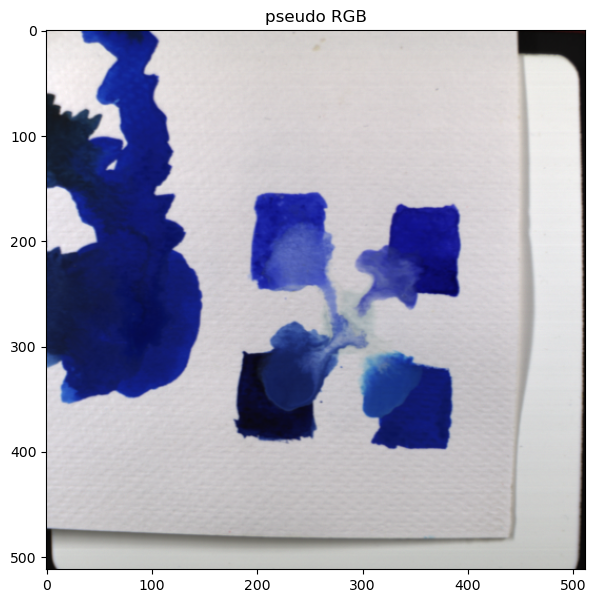

In [ ]:
fig, ax = plt.subplots(figsize=[7, 7])
ax.imshow(pseudo_rgb / pseudo_rgb.max()) # avoid clipping 
ax.set_title('pseudo RGB');

## FUNCTIONS 

In [ ]:
#|export 

import os 
import shutil 
import requests
from tqdm import tqdm 

from treelib import Tree
from os import walk 
from pathlib import Path 
import re 
import glob 

import numpy as np
import matplotlib.pyplot as plt


In [ ]:
#|export  

def download(): 
    '''Download Specim IQcam demo dataset zipfile and extract its contents. '''
    
    # check if 'downloads' folder is current working directory   
    
    cwd = os.path.basename(os.getcwd()) 
    
    if cwd != 'downloads': 
        os.makedirs('downloads', exist_ok=True)
        os.chdir('downloads') 
        cwd = os.path.basename(os.getcwd()) 
        
    print(f'Current working directory: "{cwd}"')
    
    # download zipfile 
    
    zip_file = 'iqcam_2021-02-03_005_4x-aquarelblauw-FL-01.zip' 
    url = f'https://f002.backblazeb2.com/file/iqcampy-demo/{zip_file}' 
    data_path = re.sub('\.zip$', '', zip_file) # remove extension .zip 
    
    if os.path.exists(zip_file): 
        print(f'(1/2) Found existing zipfile: {zip_file} (skipping download)')
        
    else: 
        print('(1/2) Please wait while downloading...')

        r = requests.get(url, stream=True)
        total = int(r.headers.get('content-length', 0))

        # Can also replace 'file' with a io.BytesIO object
        with open(zip_file, 'wb') as fh, tqdm(
            desc=zip_file,
            total=total,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
            ) as bar:
                for data in r.iter_content(chunk_size=1024):
                    size = fh.write(data)
                    bar.update(size)

    #extracting zipfile 
    print('(2/2) Extracting zip file...')
    shutil.unpack_archive(zip_file)
    print('Ready!')
        
    return data_path
    

    
def filetree(data_path, include_files=True, force_absolute_ids=True, show=True):
    """Prints a file tree with the contents of the `data_path` folder. 
    
    """ 
    
    tree = Tree()
    first = True
    for root, _, files in walk(data_path):
        p_root = Path(root)
        if first:
            parent_id = None
            first = False
        else:
            parent = p_root.parent
            parent_id = parent.absolute() if force_absolute_ids else parent

        p_root_id = p_root.absolute() if force_absolute_ids else p_root
        tree.create_node(tag="%s/" % (p_root.name if p_root.name != "" else "."),
                         identifier=p_root_id, parent=parent_id)
        if include_files:
            for f in files:
                f_id = p_root_id / f
                tree.create_node(tag=f_id.name, identifier=f_id, parent=p_root_id) 

    # fix treelib.tree.show() bug: 
    # see: https://stackoverflow.com/questions/46345677/treelib-prints-garbage-instead-of-pseudographics-in-python3 

    tree_str = tree.show(stdout=False)
    if show: 
        print(tree_str)
    
    return None




def read_darkref(data_path): 
    '''Read DARKREF header and data. 
    
    Returns: meta, nms, dark_spectrum
    '''
    
    # darkref filepaths      
    darkref_hdr = glob.glob(f'{data_path}/**/DARKREF*.hdr', recursive=True)[0]
    darkref_raw = glob.glob(f'{data_path}/**/DARKREF*.raw', recursive=True)[0] 

    #darkref data
    with open(darkref_hdr) as fh: 
        txt = fh.read()
        arr = np.fromfile(darkref_raw, dtype=np.uint16) 
        
    ptrn = '(?P<meta>.*)wavelength\s+=\s+\{(?P<nms>.*)\}'
    repl_meta = '\g<meta>'
    repl_nms = '\g<nms>'
    
    nms = re.sub(ptrn, repl_nms, txt, flags=re.DOTALL)
    nms = re.sub('\n', '', nms)
    nms = re.sub('\s', '', nms)
    nms = re.split(',', nms)
    nms = np.array([float(n) for n in nms])
    
    meta = re.sub(ptrn, repl_meta, txt, flags=re.DOTALL)  
    
    dark = np.mean(arr).round(1) # single dark current for all pixels 
    
    dark_spectrum = dark * np.ones_like(nms) 
        
    return meta, nms, dark_spectrum



def read_whiteref(data_path): 
    '''Read WHITEREF header and data. 
    
    Returns: meta, nms, white_spectrum
    '''
    
    # whiteref filepaths      
    whiteref_hdr = glob.glob(f'{data_path}/**/WHITEREF*.hdr', recursive=True)[0]
    whiteref_raw = glob.glob(f'{data_path}/**/WHITEREF*.raw', recursive=True)[0] 

    #darkref data
    with open(whiteref_hdr) as fh: 
        txt = fh.read()
        arr = np.fromfile(whiteref_raw, dtype=np.uint16) 
        
    ptrn = '(?P<meta>.*)wavelength\s+=\s+\{(?P<nms>.*)\}'
    repl_meta = '\g<meta>'
    repl_nms = '\g<nms>'
    
    nms = re.sub(ptrn, repl_nms, txt, flags=re.DOTALL)
    nms = re.sub('\n', '', nms)
    nms = re.sub('\s', '', nms)
    nms = re.split(',', nms)
    nms = np.array([float(n) for n in nms])
    
    meta = re.sub(ptrn, repl_meta, txt, flags=re.DOTALL)  
    
    white_spectrum = arr.reshape([204, 512]).mean(axis=1)  
        
    return meta, nms, white_spectrum 


def read_capture(data_path): 
    '''Read cube capture header and data. 
    
    Returns: meta, nms, capture_cube
    '''
    
    # capture filepaths      
    capture_hdr = glob.glob(f'{data_path}/**/iqcam*.hdr', recursive=True)[0]
    capture_raw = glob.glob(f'{data_path}/**/iqcam*.raw', recursive=True)[0] 

    #darkref data
    with open(capture_hdr) as fh: 
        txt = fh.read()
        arr = np.fromfile(capture_raw, dtype=np.uint16) 
        
    ptrn = '(?P<meta>.*)wavelength\s+=\s+\{(?P<nms>.*)\}'
    repl_meta = '\g<meta>'
    repl_nms = '\g<nms>'
    
    nms = re.sub(ptrn, repl_nms, txt, flags=re.DOTALL)
    nms = re.sub('\n', '', nms)
    nms = re.sub('\s', '', nms)
    nms = re.split(',', nms)
    nms = np.array([float(n) for n in nms])
    
    meta = re.sub(ptrn, repl_meta, txt, flags=re.DOTALL)  
    
    #capture_cube = arr.reshape([512, 204, 512])[::-1, ::-1, ::-1].transpose([2, 0, 1]).astype(float) 
    capture_cube = arr.reshape([512, 204, 512]).transpose([2, 0, 1])[:, ::-1, :].astype(float) 
        
    return meta, nms, capture_cube



def read_reflectance(data_path): 
    '''Read precomputed computed reflectance header, cube data and rgb image. 
    
    Returns: meta, nms, reflectance_cube, rgb_img
    '''
    
    # reflectance filepaths (assuming only one extracted zip file)    
    reflectance_hdr = glob.glob(f'{data_path}/**/REFLECTANCE*.hdr', recursive=True)[0]
    reflectance_dat = glob.glob(f'{data_path}/**/REFLECTANCE*.dat', recursive=True)[0] 
    png = glob.glob(f'{data_path}/**/REFLECTANCE*.png', recursive=True)[0]

    #reflectance data
    with open(reflectance_hdr) as fh: 
        txt = fh.read()
        arr = np.fromfile(reflectance_dat, dtype=np.float32) 
        rgb_img = plt.imread(png)
        
    ptrn = '(?P<meta>.*)wavelength\s+=\s+\{(?P<nms>.*)\}'
    repl_meta = '\g<meta>'
    repl_nms = '\g<nms>'
    
    nms = re.sub(ptrn, repl_nms, txt, flags=re.DOTALL)
    nms = re.sub('\n', '', nms)
    nms = re.sub('\s', '', nms)
    nms = re.split(',', nms)
    nms = np.array([float(n) for n in nms])
    
    meta = re.sub(ptrn, repl_meta, txt, flags=re.DOTALL)  
    
    reflectance_cube = arr.reshape([512, 204, 512]).transpose([2, 0, 1])[:, ::-1, :] 
    #reflectance_cube = reflectance_cube[:,:,::-1]
        
    return meta, nms, reflectance_cube, rgb_img   


def compute_reflectance(capture_cube, dark_spectrum, white_spectrum): 
    '''Compute spectral reflectance cube from raw data. 
    
    Returns: reflectance_cube
    '''
    
    reflectance_cube = (capture_cube - dark_spectrum[None, None, :]) /\
                                (white_spectrum[None, None,:] - dark_spectrum[None, None,:])
        
    return reflectance_cube 